In [1]:
%run 00_analysis_config.ipynb


/bin/bash: warning: setlocale: LC_ALL: cannot change locale (en_US.UTF-8)


Welcome to JupyROOT 6.24/06

RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt



In [7]:
import util

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import *
import scipy.signal
%config InlineBackend.figure_format='retina'

import math
from tqdm import tqdm

In [3]:
resolution_save = joblib.load( "Resolution.joblib")
charges_sipm = resolution_save["charges_sipm"]
resolutions_sipm = resolution_save["resolutions_sipm"]
charges = resolution_save["charges_sipm_wls"]
resolutions = resolution_save["resolutions_sipm_wls"]
charges_wls_cable = resolution_save["charges_sipm_wls_cable"]
resolutions_wls_cable = resolution_save["resolutions_sipm_wls_cable"]

---
# How to calculate uncertainty induced by decay time?
1. ToyMC

In [4]:
def make_kernel_dummypulse(pre_trig, post_trig,tau1=2,tau2=20,AC_coulpled=False, Fs = 100):
    # Fs: samples per s
    x = np.arange(0,(pre_trig+post_trig))/Fs
    x0 = pre_trig/Fs
    dx=(x-x0)
    dx*=np.heaviside(dx,1)
    kernel = (np.exp(-dx/tau1)-np.exp(-dx/tau2))/(tau1-tau2)*np.heaviside(dx,1)
    # kernel_normed = kernel/(np.dot(kernel,kernel/max(kernel)))
    kernel_normed = kernel/np.max(kernel)

    return kernel_normed


def roll_zeropad(a, shift):
    y = np.roll(a,shift)
    y[:shift]=0
    return y

In [20]:
# 2. Toy MC

# Signal size and trigger
n_expected = 120 # number of eh expected
n_threshold = 4.5 # threshold [eh]

# WLS fiber parameter
WLS_t_decay = 2.7 # [ns]
# WLS_t_decay = 0.1 # [ns]
# Laser parameter
LASER_time_spread = 0.15 # [ns], sigma, Gaus wavelet


# Run parameters
N_EXPERIMENTS = 10_000
N_PLOTS = 200
SEED = 1

# Pulse parameters
Fs=50 # 50 samples per ns
TR=2 # rise time 2 ns
TF=20 # fall time 20 ns
PULSE_DURATION = 50 #ns




PULSE = make_kernel_dummypulse(0,PULSE_DURATION*Fs,tau1 = TR,tau2 = TF,AC_coulpled = False, Fs=Fs)
TIME_SERIES = np.linspace(0,PULSE_DURATION,PULSE_DURATION*Fs)
RNG = np.random.default_rng(seed=SEED)


results_trigger_time = []
results_pulses = []
for i in tqdm(range(N_EXPERIMENTS)):
    # Get the actual numer of photons by Sampling from poisson
    n_gen = RNG.poisson(lam=n_expected)
    
    if n_gen>0:
        pulse_this = np.zeros_like(PULSE)
        # Get the time of each photon by sampling from Gauss
        time_gen = RNG.normal(loc=LASER_time_spread*7, scale=LASER_time_spread*7, size=n_gen)

        # Get the decay time of each photon by sampling from exponential
        time_decay = time_gen + RNG.exponential(scale=WLS_t_decay, size=n_gen)
            
        for iphoton in range(n_gen):
            if time_decay[iphoton]>0 and time_decay[iphoton]<PULSE_DURATION:
                # Roll and pile one more pulse to the final pulse
                pulse_this+=roll_zeropad(PULSE, int(time_decay[iphoton]*Fs))
                
        results_trigger_time.append(np.argmax(pulse_this>n_threshold))
        
        if i<N_PLOTS:
            results_pulses.append(pulse_this)
            
results_trigger_time=np.array(results_trigger_time)            

100%|██████████| 10000/10000 [01:21<00:00, 121.99it/s]


In [7]:
# reload(rt)

<module 'include_modules_root' from '/project/def-mdiamond/tomren/jupyter/Mu_helper/muhelper/include_modules_root.py'>

In [ ]:
# c1 = rt.tcanvas()
# h = rt.thist(results_trigger_time/Fs, range=(0.1,15),bins=100);
# # h.Draw()
# # h.xlabel("Trigger time [ns]")
# # h.ylabel("Trigger time [ns]")
# h.Fit("gaus", option = 'S',xmin = 0, xmax = 3)

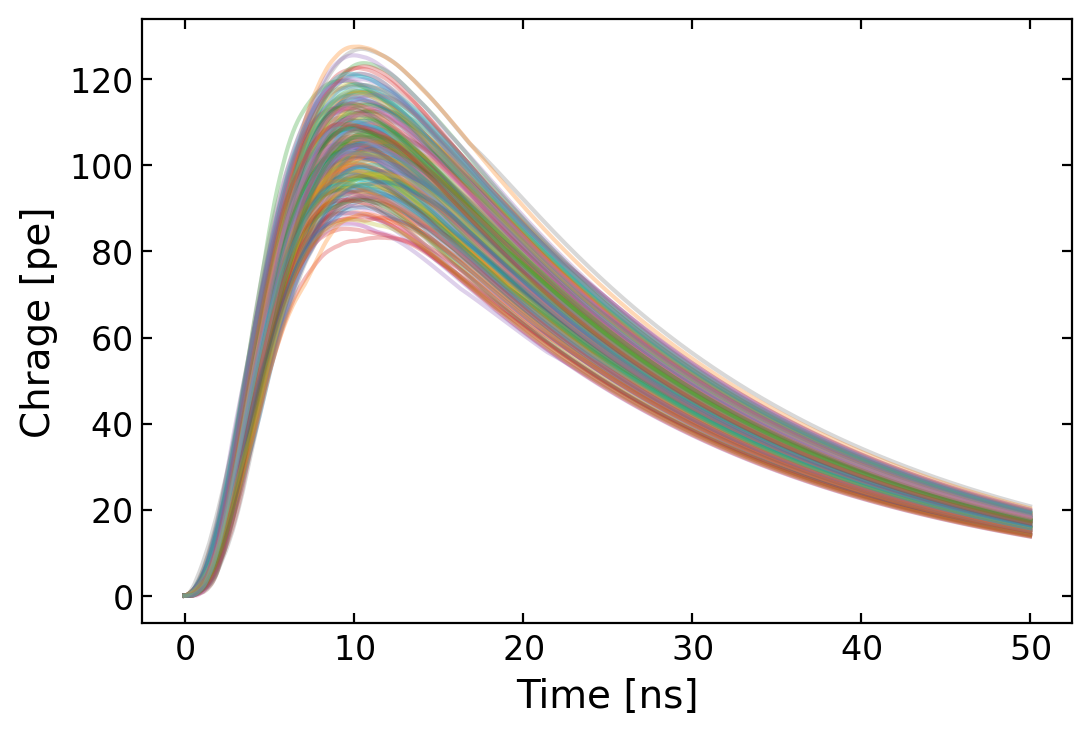

0.1563567495070281


Text(0, 0.5, 'Counts')

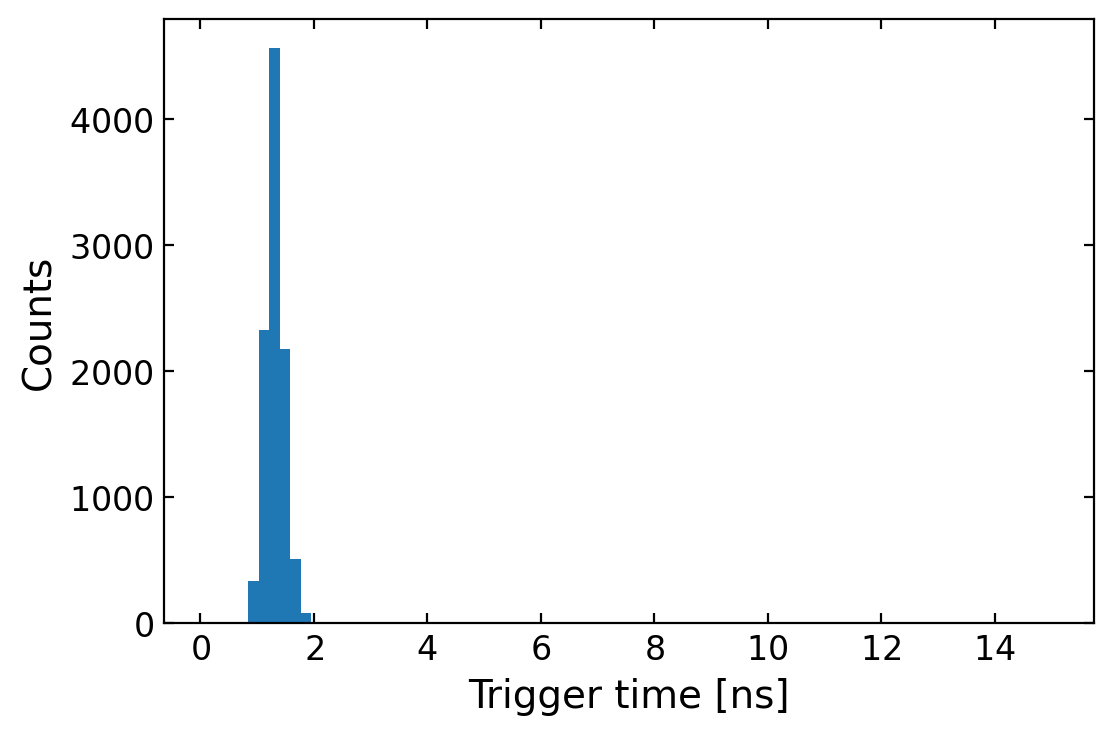

In [21]:
for pulse_this in results_pulses:
    plot(TIME_SERIES, pulse_this, alpha=0.3)  
            
xlabel("Time [ns]")
ylabel("Chrage [pe]")
show()

n,ibins,p=hist(results_trigger_time/Fs, range=(0.1,15),bins=80);
fwhm = util.Utils.fwhm(ibins[:-1],n)
print((fwhm[1]-fwhm[0])/2.355)
xlabel("Trigger time [ns]")
ylabel("Counts")

In [73]:
def mc_laser_wls(n_expected, n_threshold, WLS_t_decay, LASER_time_spread, N_EXPERIMENTS =4000, N_PLOTS=200, SEED=1, TR=1, TF=20, Fs=200, PULSE_DURATION=50):

    # # Signal size and trigger
    # n_expected = 13.5 # number of eh expected
    # n_threshold = 4.5 # threshold [eh]

    # # WLS fiber parameter
    # WLS_t_decay = 2.7 # [ns]
    # # Laser parameter
    # LASER_time_spread = 0.15 # [ns], sigma, Gaus wavelet


    # # Run parameters
    # N_EXPERIMENTS = 10_000
    # N_PLOTS = 200
    # SEED = 1

    # # Pulse parameters
    # Fs=100 # 100 samples per ns
    # TR=2 # rise time 2 ns
    # TF=20 # fall time 20 ns
    # PULSE_DURATION = 50 #ns




    PULSE = make_kernel_dummypulse(0,PULSE_DURATION*Fs,tau1 = TR,tau2 = TF,AC_coulpled = False, Fs=Fs)
    TIME_SERIES = np.linspace(0,PULSE_DURATION,PULSE_DURATION*Fs)
    RNG = np.random.default_rng(seed=SEED)

    results_trigger_time = []
    results_pulses = []
    for i in tqdm(range(N_EXPERIMENTS)):
        # Get the actual numer of photons by Sampling from poisson
        n_gen = RNG.poisson(lam=n_expected)

        if n_gen>0:
            pulse_this = np.zeros_like(PULSE)
            # Get the time of each photon by sampling from Gauss
            time_gen = RNG.normal(loc=LASER_time_spread*7, scale=LASER_time_spread*7, size=n_gen)

            # Get the decay time of each photon by sampling from exponential
            time_decay = time_gen + RNG.exponential(scale=WLS_t_decay, size=n_gen)

            for iphoton in range(n_gen):
                if time_decay[iphoton]>0 and time_decay[iphoton]<PULSE_DURATION:
                    # Roll and pile one more pulse to the final pulse
                    pulse_this+=roll_zeropad(PULSE, int(time_decay[iphoton]*Fs))

            results_trigger_time.append(np.argmax(pulse_this>n_threshold))

            if i<N_PLOTS:
                results_pulses.append(pulse_this)

    results_trigger_time=np.array(results_trigger_time)   
    results_pulses=np.array(results_pulses)
    
    return results_trigger_time, results_pulses

100%|██████████| 10000/10000 [00:10<00:00, 956.93it/s]


---

In [18]:
# 1. analytical
t_decay = 2.7 # ns
n_expected = 40 # number of eh expected
n_threshold = 4 # threshold

time_series = np.linspace(0.1,10,100)
prob_series = []
for t in time_series:
    # prob_single = np.exp(-t/t_decay)
    prob_single = scipy.stats.expon.cdf(t/t_decay)
    prob_triggered = np.power(prob_single, n_threshold)* np.power(1-prob_single, n_expected-n_threshold) * math.comb(n_expected,n_threshold)
    prob_series.append(prob_triggered)
prob_series=np.array(prob_series)

0.1444248051117692


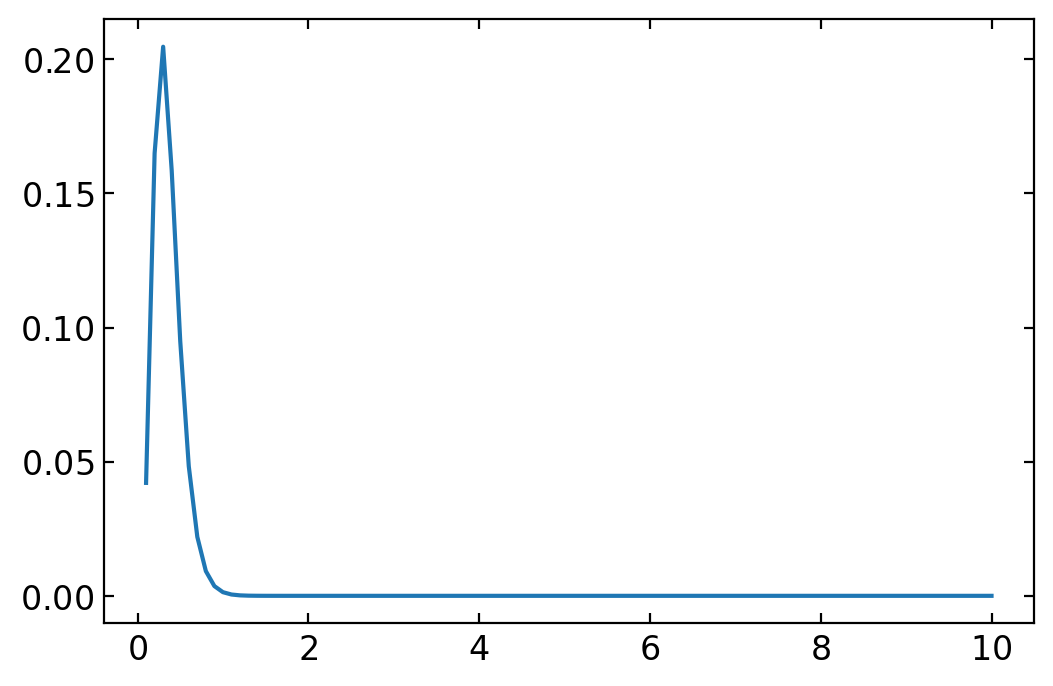

In [19]:
plot(time_series, prob_series)
fwhm = util.Utils.fwhm(time_series,prob_series,)
print((fwhm[1]-fwhm[0])/2.35)